![](header.jpg)

# Omni Camera

Kevin J. Walchko

3 Apr 2018

---

![](lense.jpg)

A catadioptric sensor is a camera made up of a mirror (catoptrics) and lenses (dioptrics). By simplifying things a lot, one can think of a catadioptric sensor as consisting of a normal camera viewing the world reflected in a parabolic-shaped mirror. To be useful, the mirror must be perfectly aligned with and placed at a precise distace from the camera. The main advantage of a catadioptric sensor is its panoramic view of the world, being able to view a full hemisphere (360 degrees by 90 degrees). 

<img src="robot.jpg" width="300px">

Now for robotics, this offers a potential oppertunity for a sensor with 360$^\circ$ FOV. There are also examples of this process being done in stereo.

<img src="vo.gif">

Once the image is dewarped, you can perform a lot of standard computer vision operations like the video odometry shown above. Video odometry is where you calculate the optical flow and determine the path a robot has taken.

![](image.png)



## References

- [Katherine Scott](http://www.kscottz.com/dewarped-panoramic-images-from-a-raspberrypi-camera-module/)
- [Mark Borg](https://mark-borg.github.io/projects/omniapp)
- [wikipedia](https://en.wikipedia.org/wiki/Omnidirectional_camera)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Dewarping

Katherine Scott has laid out the equations below:

![](math.jpg)

In [2]:
class Dewarper:
    def __init__(self, Ws, Hs, Rmax, Rmin, Cx, Cy, interpolation=cv2.INTER_CUBIC):
        self.interpolation = interpolation

        # determine the destination image size
        Wd = int(2.0*(float(Rmax+Rmin)/2.0)*np.pi)
        Hd = Rmax-Rmin

        print('Unwrapped image size:',Wd,Hd)

        self.buildLUT(Wd, Hd, Rmax, Rmin, Cx, Cy)

    """ 
    Creates a polar map look up table (LUT)
    in:
        Wd - width destination
        Hd - height destination
        Ws - width src
        Hs - height src
        Rmin - inner ring of image
        Rmax - outer ring of image
        Cx - camera center x
        Cy - camera center y
    out: mapping matrix
    """
    def buildLUT(self, Wd, Hd, Rmax, Rmin, Cx, Cy):
        map_x = np.zeros((Hd, Wd), np.float32)
        map_y = np.zeros((Hd, Wd), np.float32)

        # polar to Cartesian
        # x = r*cos(t)
        # y = r*sin(t)
        for i in range(0,int(Hd)):
            for j in range(0,int(Wd)):
                theta = -float(j)/float(Wd)*2.0*np.pi
                rho = float(Rmin + i)
                map_x.itemset((i,j), Cx + rho*np.cos(theta))
                map_y.itemset((i,j), Cy + rho*np.sin(theta))

        (self.map1, self.map2) = cv2.convertMaps(map_x, map_y, cv2.CV_16SC2)


    """
    Takes the original image and unwarps it, note the new image is much smaller
    in: raw image needing to be unwarped
    out: panoramic image
    """
    def unwarp(self, img):
        output = cv2.remap(img, self.map1, self.map2, self.interpolation)
        return output


In [3]:
def process(file, rmin):
    # read in the image grayscale
    frame = cv2.imread(file,0)
    h,w = frame.shape
    print('Image size:',w,h)

    # These are done by hand ... had trouble automating it reliably
    cx = int(w/2)
    cy = int(h/2)
    rmax = cy - rmin

    print('Parameters: center(x,y) %d,%d radius(max,min) %d,%d'%(cx,cy,rmax,rmin))

    dewarp = Dewarper(w,h,rmax,rmin,cx,cy)
    im = dewarp.unwarp(frame)
    
    return im, frame

## Football

The camera captures the circular image below. Now because the center of the reflective mirror is down and the outside edge of the circle is up, when the image is dewarped, the image appears upside down. Therefore we use `cv2.flip` to invert the image so it looks correct.

Image size: 1414 1402
Parameters: center(x,y) 707,701 radius(max,min) 551,150
Unwrapped image size: 2202 401


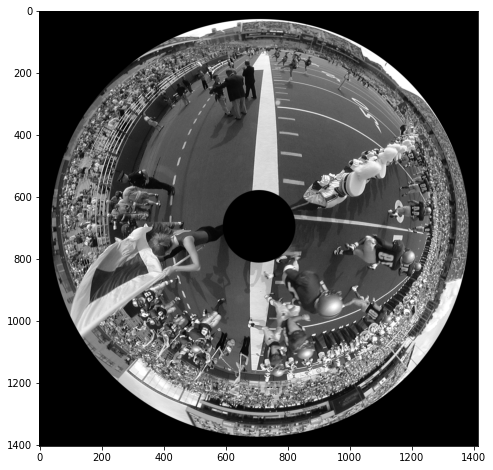

In [19]:
im, orig = process('football_donut.jpg', 150)

plt.subplots(1,1,figsize=(8,8))
plt.imshow(orig, cmap='gray');

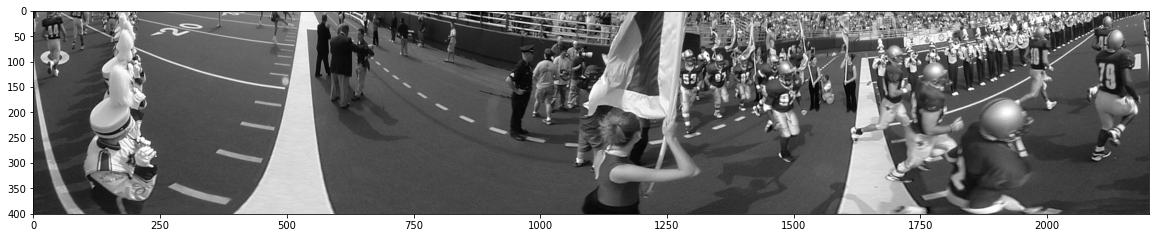

In [20]:
plt.subplots(1,1,figsize=(20,8))
plt.imshow(cv2.flip(im,0), cmap='gray');

## Office

Image size: 640 480
Parameters: center(x,y) 320,240 radius(max,min) 230,10
Unwrapped image size: 753 220


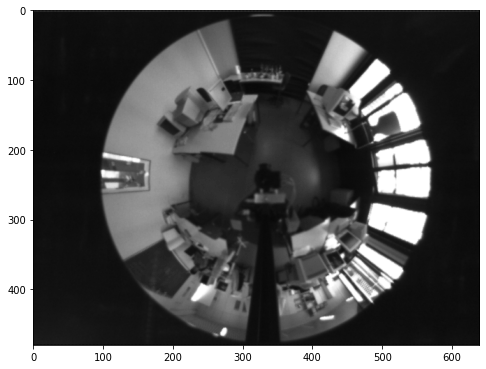

In [17]:
im, org = process('in.jpg',10)

plt.subplots(1,1,figsize=(8,8))
plt.imshow(org, cmap='gray');

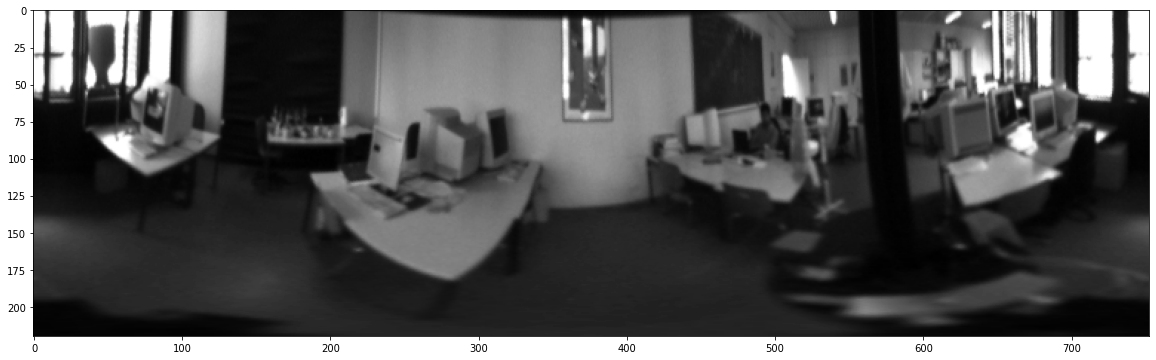

In [18]:
plt.subplots(1,1,figsize=(20,8))
plt.imshow(cv2.flip(im,0), cmap='gray');

## Chinese Theater

Now, unlike the previous 2 image, this lense is setup different and the center of the image is up and the outside edge is down. Therefore, we don't have to use `cv2.flip` on this one. The camera is designed and setup different than the two previous ones.

Image size: 329 329
Parameters: center(x,y) 164,164 radius(max,min) 134,30
Unwrapped image size: 515 104


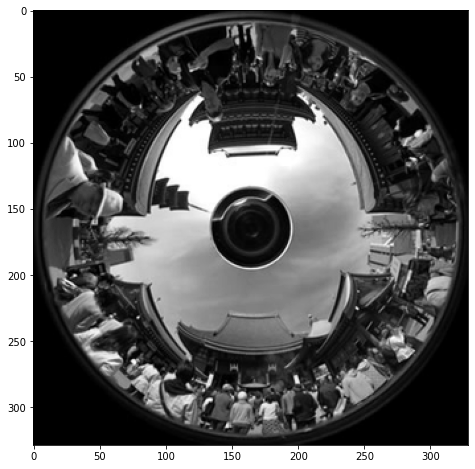

In [9]:
im, org = process('image2.png',30)

plt.subplots(1,1,figsize=(8,8))
plt.imshow(org, cmap='gray');

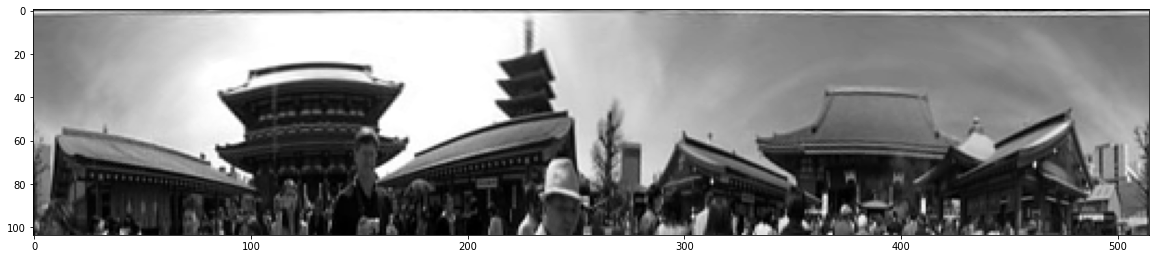

In [15]:
plt.subplots(1,1,figsize=(20,8))
plt.imshow(im, cmap='gray');